In [30]:
import cv2
cv2.__version__

'4.5.4'

In [31]:
# import sample data
from skimage.data import cells3d
#import ndimage

import napari
import vispy.color
import vtk
import tetgen
import scipy
import statistics as st
import pymeshlab
import xlsxwriter

import numpy as np

import cv2 as cv
import matplotlib.pyplot as plt
import SimpleITK as sitk
import meshlib
import pyvista as pv
import meshio

from csbdeep.utils import normalize
from scipy import ndimage as ndi

from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from vispy.color import Colormap
from IPython.display import display_html

from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

from napari.settings import get_settings

import meshlib.mrmeshpy as mr
import meshlib.mrmeshnumpy as mrn

from vispy.color import Colormap
from IPython.display import display_html

from aicsimageio import AICSImage

from skimage.measure import marching_cubes
#from mayavi import mlab
from scipy.spatial import Delaunay

settings = get_settings()
settings.application.ipy_interactive = True

In [32]:
# Get the AICSImage object
zstack_file='2024-w19-primary-lecs-20X.lif' 
img = AICSImage(zstack_file)
#imgdata = img.get_image_data("CZYX", T=0) 
#img.set_scene(6)

In [33]:
img.get_image_dask_data("YZX")  # dask.array.Array

dask.array<transpose, shape=(1954, 63, 20301), dtype=uint8, chunksize=(1954, 63, 20301), chunktype=numpy.ndarray>

In [34]:
original_ch_names=img.channel_names

In [35]:
r_X=img.physical_pixel_sizes.X
r_Y=img.physical_pixel_sizes.Y
r_Z=img.physical_pixel_sizes.Z
#r_X*=1.8
#r_Y*=1.8
#r_Z/=1.8
print([r_X,r_Y,r_Z])

[0.5664162561576355, 0.5664162826420891, 6.000048387096774]


In [36]:
a=[0,0,1,1]
b=[0,1,0,1]

#### Functions

In [37]:
def non_proc(im_in):
    return im_in.copy()

def ln_trans(im_in):
    val_c = 255.0 / np.log(1.0 + np.max(im_in))
    im_out = (val_c * (np.log(im_in + 1.0))).astype(int)
    return im_out.copy()

def exp_trans(im_in,val_a):
    val_c = 255.0 / ((1.0 + val_a)**np.max(im_in) - 1.0)
    im_out = (val_c*((1.0 + val_a)**im_in - 1.0))
    return im_out.copy()

def gamma_trans(im_in,gamma):
    val_c = 255.0 / (np.max(im_in)**gamma)
    im_out = val_c*(im_in**gamma)
    return im_out.copy()

def hist_slide_inc(im_in,shift_in):
    lim=255-shift_in
    im_out[im_in > lim] = 255
    im_out[im_in <= lim] += shift_in
    return im_out.copy()

def hist_slide_dec(im_in,shift_dec):
    lim=shift_dec
    im_out[im_in < lim] = 0
    im_out[im_in >= lim] -= shift_dec
    return im_out.copy()

def cont_stretch(im_in):
    val_a, val_b = 0.0, 255.0
    val_c, val_d = im_in.min(), im_in.max()
    im_out=((im_in-val_c)*((val_b - val_a)/(val_d-val_c)) + val_a).astype(int)
    return im_out.copy()

def contr_limit(im_in,c_min,c_max):
    alpha = 255.0/(c_max - c_min)
    beta = - c_min * (alpha)
    im_out=(np.clip(alpha*im_in+beta, 0.0, 255.0)).astype(int)
    #print(np.max(im_out))
    return im_out.copy()
    
def histo_equal(im_in):
    h=im_in.shape[1]
    w=im_in.shape[2]
    r=im_in.shape[0]

    tot_pixs=h*w*r

    levels=256

    im_hist = np.zeros((levels))

    for i in range(0,levels):
        im_hist[i] = np.count_nonzero(im_in == i)

    pdf = np.zeros((levels))
    for i in range(0,levels):
        pdf[i] = im_hist[i]/tot_pixs

    cdf = np.zeros((levels))
    cdf[0] = pdf[0]
    for i in range(1, levels):
        cdf[i] = pdf[i] + cdf[i-1]

    im_out=im_in.copy()
        
    for u in range(0,r):
        for j in range(0,h):
            for k in range(0,w):
                im_out[u,j,k] = int(round((levels-1) * cdf[im_in[u,j,k]]))
    return im_out.copy()

## MULTIPLE TRANSFORM

##### [options: non_proc(im_in), ln_trans(im_in), exp_trans(im_in,val_a), gamma_trans(im_in,gamma), hist_slide_inc(im_in,shift_in), hist_slide_dec(im_in,shift_dec), cont_stretch(im_in), histo_equal(im_in)]

In [38]:
trig_show_original=True
trig_remove_noise=True
trig_transform=True
trig_filter=True
trig_threshold=True
trig_watershed=True
trig_stardist=False
trig_vtk_creation=True
trig_stl_creation=True

In [42]:
colormaps=['green','blue']
ch_names=['C1', 'DAPI']
coord_order='ZYX'
if trig_show_original:
    viewer_0 = napari.Viewer()
    for c, c_name in enumerate(ch_names):
        im_in=img.get_image_data(coord_order, C=c, S=0, T=0)
        im_in=im_in[:,:,6000:7200].copy()
        #img.set_scene(2)
        viewer_0.add_image(im_in, name=c_name, 
                            colormap=colormaps[c], blending='additive')

##### Test the function for histogram transformation here

In [43]:
colormaps=['green','blue']
ch_names=['C1', 'DAPI']
coord_order='ZYX'
if trig_show_original:
    viewer_0 = napari.Viewer()
    for c, c_name in enumerate(ch_names):
        im_in=img.get_image_data(coord_order, C=c, S=0, T=0)
        im_in=im_in[:,:,6000:7200].copy()
        #img.set_scene(2)
        
        #im_in=(256.0*im_in/4096.0).astype('uint8') 
    
        im_out=im_in.copy()
        print_im=im_out.copy()
    
        # REMOVE NOISE
        im_in=im_out.copy()
        
        if trig_remove_noise:
            im_out=filters.median(im_in)
    
            print_im_0=im_out.copy()
                
        # #FILTERING
        im_in=im_out.copy()
            
        if trig_filter:
            im_out=filters.gaussian(im_in,0.5,preserve_range=True)
            
        print_im_0=im_out.copy()

        #HISTOGRAM TRANSFORMATION
        im_in=im_out.copy()
    
        if trig_transform:
    
            func_list=[contr_limit(im_in,0.0,10.0),contr_limit(im_in,0.0,54.0),contr_limit(im_in,4.0,60.0)]
            #func_list=[non_proc(im_in),non_proc(im_in),non_proc(im_in),non_proc(im_in)]
    
            im_out=func_list[c]
            im_trans=im_out.copy()
            print_im=im_out.copy()

        #NAPARI UPLOAD
        viewer_0.add_image(print_im, name=c_name, 
                            colormap=colormaps[c], blending='additive')
    
        viewer_0.scale_bar.visible=True
        viewer_0.scale_bar.unit='um'

In [12]:
## TESTED FUNCTIONS


In [ ]:
r_Z=2.0
from IPython.display import clear_output

viewer_0 = napari.Viewer()
viewer_1 = napari.Viewer()
img = AICSImage(zstack_file) 

#img.set_scene(6)

colormaps=['green','blue']
ch_names=['C1', 'DAPI']
coord_order='ZYX'

#train_scale=[1.0/r_Z,1.0/r_Y,1.0/r_X]
train_scale=[r_Z,r_Y,r_X]
train_factor=[1.0,1.0,1.0]
#img.set_scene(2)

fig, axs = plt.subplots(2,2)

for c, c_name in enumerate(ch_names):
    im_in_0=img.get_image_data(coord_order, C=c, S=0, T=0)
    #im_in=im_in_0.copy()
    im_in=im_in_0[:,:,4000:5000].copy()
    #img.set_scene(2)
    
    #im_in=(256.0*im_in/4096.0).astype('uint8') 

    im_out=im_in.copy()
    print_im=im_out.copy()

    # REMOVE NOISE
    im_in=im_out.copy()
    
    if trig_remove_noise:
        im_out=filters.median(im_in)

        print_im=im_out.copy()
        
    #FILTERING
    im_in=im_out.copy()
    
    if trig_filter:
        im_out=filters.gaussian(im_in,0.5,preserve_range=True)
        
        print_im=im_out.copy()

    #HISTOGRAM TRANSFORMATION
    im_in=im_out.copy()

    if trig_transform:

        func_list=[contr_limit(im_in,1.0,50.0),contr_limit(im_in,1.0,50.0),contr_limit(im_in,4.0,60.0)]
        #func_list=[non_proc(im_in),non_proc(im_in),non_proc(im_in),non_proc(im_in)]

        im_out=func_list[c]
        im_trans=im_out.copy()
        print_im=im_out.copy()

    #THRESHOLDING
    im_in=im_out.copy()
    
    if trig_threshold:
        nda=sitk.GetImageFromArray(im_in)
        
        otsu_filter = sitk.OtsuThresholdImageFilter()
        otsu_filter.SetInsideValue(0)
        otsu_filter.SetOutsideValue(200)
        seg = otsu_filter.Execute(nda)
    
        val=otsu_filter.GetThreshold()
        print(val)
        
        im_out=sitk.GetArrayFromImage(seg)
        im_th=im_out.copy()
        print_im_1=im_out.copy()

    #FILTERING
    im_in=im_out.copy()
    
    if not(trig_threshold & trig_filter):
        im_out=filters.gaussian(im_in,1.0,preserve_range=True)
        im_out=im_out.astype('uint8')
        
    print_im_0=im_out.copy()

    #WATERSHED
    im_in=im_out.copy()
    #im_th=im_out.copy()

    labels=im_th.copy()
    im_labels=im_trans.copy()
    
    if trig_watershed and ch_names[c]=='DAPI':
        if trig_stardist:
            model = StarDist3D.from_pretrained('3D_demo')
            img_te = normalize(im_labels,1.0,99.8)
            #labels, _ = model.predict_instances(img_te,prob_thresh=0.7, nms_thresh=0.2)
            labels, _ = model.predict_instances(img_te,scale=(1.8,r_Y,r_X),prob_thresh=0.71, nms_thresh=0.3)
            #labels, _ = model.predict_instances(img_te,scale=(1.0/train_factor[0],1.0/train_factor[1],1.0/train_factor[2]),prob_thresh=0.7, nms_thresh=0.2)
            im_mask=im_th/np.max(im_th)
            im_mask=ndi.binary_erosion(im_mask,structure=np.ones((2,2,2))).astype(im_mask.dtype)
            im_positive=labels*(im_mask)
            list_positive=list(np.unique(im_positive))
            list_positive=list_positive[1:]
            print('TOTAL NUCLEI ' + str(len(list_positive)))
        else:
            distance = ndi.distance_transform_edt(im_in)
            coords = peak_local_max(distance, footprint=np.ones((3,3,3)), labels=im_in.astype('uint8'))
            mask = np.zeros(distance.shape, dtype=bool)
            mask[tuple(coords.T)] = True
            markers, _ = ndi.label(mask)
            labels = watershed(-distance, markers, mask=im_in)
            im_mask=im_th/np.max(im_th)
            im_mask=ndi.binary_erosion(im_mask,structure=np.ones((2,2,2))).astype(im_mask.dtype)
            im_positive=labels*(im_mask)
            list_positive=list(np.unique(im_positive))
            list_positive=list_positive[1:]
            print('TOTAL NUCLEI ' + str(len(list_positive)))

    cm=np.random.rand(1000,3)
    cm[0,:]=[0.0,0.0,0.0]
    colormaps_water=Colormap(cm)

    lab_0=labels.copy()

    globals()[c_name+'lab']=labels.copy()
    globals()[c_name+'mag']=im_labels.copy()
    print_im_water=labels.copy()

    #VTK NUCLEI and CYTOPLASM CREATOR LABELLED

    if trig_watershed and trig_vtk_creation and ch_names[c]=='DAPI':
        diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
        cytolab=np.zeros(np.shape(DAPIlab))
        blocks_nuclei=pv.MultiBlock()
        blocks_cyto=pv.MultiBlock()
        nuclei_stl_old=mr.Mesh()
        cyto_stl_old=mr.Mesh()
        
        agg=[]
        agg_k=[]
        agg_done=[]
        agg_k_done=[]
        agg_size=[]
        agg_cyto_vol=[]
        agg_nuc_vol=[]
        agg_nuc_coord=[]
        agg_cyto_coord=[]
        agg_ass=np.zeros((len(list_positive)+1,))
        nuc_vol=np.zeros((len(list_positive)+1,))
        cyto_vol=np.zeros((len(list_positive)+1,))
        nuc_coord=np.zeros((len(list_positive)+1,3))
        cyto_coord=np.zeros((len(list_positive)+1,3))
        agg_id=1

        # EVALUATE CYTOPLASM AS % MORE VOLUME COMPARED TO DAPI
        
        for j, val in enumerate(list_positive):
            clear_output()
            print('NUCLEI ' + str(j) + ' / ' + str(len(list_positive)))
            simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(DAPIlab==val))
            floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
            mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)    
            mr.saveMesh(mesh_stl, "part_nuclei_mesh.stl" )
            
            mesh_nuclei = pv.read("part_nuclei_mesh.stl")
            if mesh_nuclei.volume>1:
                mesh_nuclei.decimate(target_reduction=0.8, inplace=True)
            
            #mesh_nuclei.cell_data['nuceli_id']=np.ones(mesh_nuclei.n_cells)*j

            nuc_vol[j]=mesh_nuclei.volume
            nuc_coord[j]=mesh_nuclei.center
            #mesh_nuclei.cell_data['nuclei_vol']=np.ones(mesh_nuclei.n_cells)*mvol

            cyto_vol_control=nuc_vol[j]
            vol_iter=0
            mesh_cyto=mesh_nuclei
            while cyto_vol_control<=nuc_vol[j]*(1.0+0.0):
                vol_iter+=1
                #print(vol_iter)
                cyto_geo = ndi.binary_dilation(DAPIlab==val, diamond, iterations=vol_iter)
                cyto_geo*=((DAPIlab==val)+(cytolab==0))
                #cyto_geo*=((DAPIlab==val)+((DAPIlab==0)*(cytolab==0)))
                simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(cyto_geo))
                floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
                mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)    
                mr.saveMesh(mesh_stl, "part_cyto_mesh.stl" )
                
                mesh_cyto = pv.read("part_cyto_mesh.stl")
                if mesh_cyto.volume>1:
                    mesh_cyto.decimate(target_reduction=0.8, inplace=True)
                cyto_vol_control=mesh_cyto.volume

            cyto_vol[j]=mesh_cyto.volume
            cyto_coord[j]=mesh_cyto.center
            #print(np.shape(DAPIlab))
            cytolab+=(cyto_geo*(j+1)*(cytolab==0))

        for j, val in enumerate(list_positive):
            j=j+1
            simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(DAPIlab==val))
            floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
            mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)    
            mr.saveMesh(mesh_stl,"part_nuclei_mesh.stl" )
            
            mesh_nuclei = pv.read("part_nuclei_mesh.stl")
            if mesh_nuclei.volume>1:
                mesh_nuclei.decimate(target_reduction=0.8, inplace=True)

            simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(cytolab==j))
            floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
            mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)    
            mr.saveMesh(mesh_stl,"part_cyto_mesh.stl" )
            
            mesh_cyto = pv.read("part_cyto_mesh.stl")
            if mesh_cyto.volume>1:
                mesh_cyto.decimate(target_reduction=0.8, inplace=True)

            mesh_nuclei.cell_data['nuceli_id']=np.ones(mesh_nuclei.n_cells)*j
            mesh_nuclei.cell_data['nuclei_vol']=np.ones(mesh_nuclei.n_cells)*nuc_vol[j-1]
            # mesh_nuclei.cell_data['nuclei_'+coord_order[0]]=np.ones(mesh_nuclei.n_cells)*nuc_coord[j-1][0]
            # mesh_nuclei.cell_data['nuclei_'+coord_order[1]]=np.ones(mesh_nuclei.n_cells)*nuc_coord[j-1][1]
            # mesh_nuclei.cell_data['nuclei_'+coord_order[2]]=np.ones(mesh_nuclei.n_cells)*nuc_coord[j-1][2]
            # mesh_nuclei.cell_data['nuclei_agg_'+coord_order[0]]=np.ones(mesh_nuclei.n_cells)*agg_nuc_coord[int(agg_ass[j-1])-1][0]
            # mesh_nuclei.cell_data['nuclei_agg_'+coord_order[1]]=np.ones(mesh_nuclei.n_cells)*agg_nuc_coord[int(agg_ass[j-1])-1][1]
            # mesh_nuclei.cell_data['nuclei_agg_'+coord_order[2]]=np.ones(mesh_nuclei.n_cells)*agg_nuc_coord[int(agg_ass[j-1])-1][2]
            mesh_nuclei.cell_data['nuclei_X']=np.ones(mesh_nuclei.n_cells)*nuc_coord[j-1][0]
            mesh_nuclei.cell_data['nuclei_Y']=np.ones(mesh_nuclei.n_cells)*nuc_coord[j-1][1]
            mesh_nuclei.cell_data['nuclei_Z']=np.ones(mesh_nuclei.n_cells)*nuc_coord[j-1][2]

            mesh_cyto.cell_data['cyto_id']=np.ones(mesh_cyto.n_cells)*j
            mesh_cyto.cell_data['cyto_vol']=np.ones(mesh_cyto.n_cells)*cyto_vol[j-1]
            # mesh_cyto.cell_data['cyto_'+coord_order[0]]=np.ones(mesh_cyto.n_cells)*cyto_coord[j-1][0]
            # mesh_cyto.cell_data['cyto_'+coord_order[1]]=np.ones(mesh_cyto.n_cells)*cyto_coord[j-1][1]
            # mesh_cyto.cell_data['cyto_'+coord_order[2]]=np.ones(mesh_cyto.n_cells)*cyto_coord[j-1][2]
            # mesh_cyto.cell_data['cyto_agg_'+coord_order[0]]=np.ones(mesh_cyto.n_cells)*agg_cyto_coord[int(agg_ass[j-1])-1][0]
            # mesh_cyto.cell_data['cyto_agg_'+coord_order[1]]=np.ones(mesh_cyto.n_cells)*agg_cyto_coord[int(agg_ass[j-1])-1][1]
            # mesh_cyto.cell_data['cyto_agg_'+coord_order[2]]=np.ones(mesh_cyto.n_cells)*agg_cyto_coord[int(agg_ass[j-1])-1][2]
            mesh_cyto.cell_data['cyto_X']=np.ones(mesh_cyto.n_cells)*cyto_coord[j-1][0]
            mesh_cyto.cell_data['cyto_Y']=np.ones(mesh_cyto.n_cells)*cyto_coord[j-1][1]
            mesh_cyto.cell_data['cyto_Z']=np.ones(mesh_cyto.n_cells)*cyto_coord[j-1][2]

            j=j-1
            blocks_nuclei.append(mesh_nuclei)
            blocks_cyto.append(mesh_cyto)
        
        blocks_nuclei.extract_geometry().save(zstack_file[:-4]+'_DAPI_nuclei_labelled.vtk')
        blocks_cyto.extract_geometry().save(zstack_file[:-4]+'_DAPI_cytoplasm_labelled.vtk')

    #NAPARI UPLOAD
    viewer_0.add_image(labels, name=c_name, 
                        colormap=colormaps[c], blending='additive')
    viewer_1.add_image(print_im_0, name=c_name, 
                        colormap=colormaps[c], blending='additive')

    viewer_0.scale_bar.visible=True
    viewer_0.scale_bar.unit='um'
    viewer_1.scale_bar.visible=True
    viewer_1.scale_bar.unit='um'

    #print(np.shape(labels))
    #print(np.shape(im_mask))
    
    #STL CREATOR
    if trig_stl_creation:
        simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_th))
        floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
        mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)    
        mr.saveMesh(mesh_stl, zstack_file[:-4]+"_"+ch_names[c]+"_mesh.stl" )

    #HISTOGRAM PLOTTING
    hist,bins = np.histogram(im_in_0.flatten(),256,[0,256])
    
    cdf = hist.cumsum()
    cdf_normalized = cdf* hist.max()/ cdf.max()

    axs[a[c],b[c]].plot(cdf_normalized, color = 'b')
    axs[a[c],b[c]].hist(im_in_0.flatten(),256,[0,256], color = 'r')
    axs[a[c],b[c]].set_xlim([0,256])
    #axs[a[c],b[c]].set_ylim([0,100])
    axs[a[c],b[c]].legend(('cdf','histogram'), loc = 'upper left'),
    if trig_threshold:
        axs[a[c],b[c]].plot([val,val],[0,cdf_normalized.max()],color='g')
    axs[a[c],b[c]].set_title(c_name)
    axs[a[c],b[c]].set_yscale('log')

NUCLEI 26 / 7566


## QUANTIFICATION

TOTAL NUCLEI 347


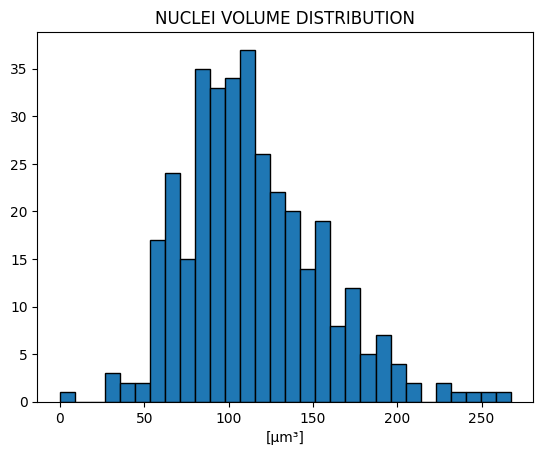

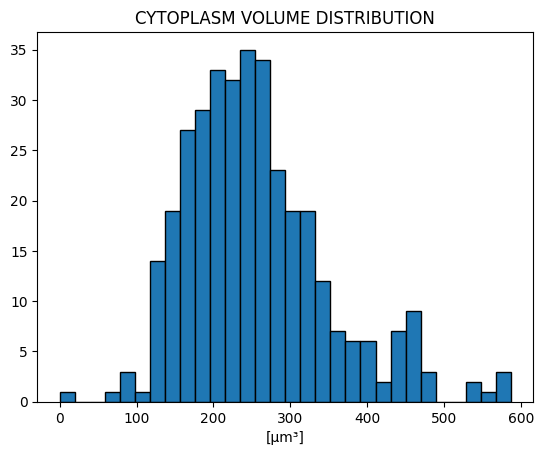

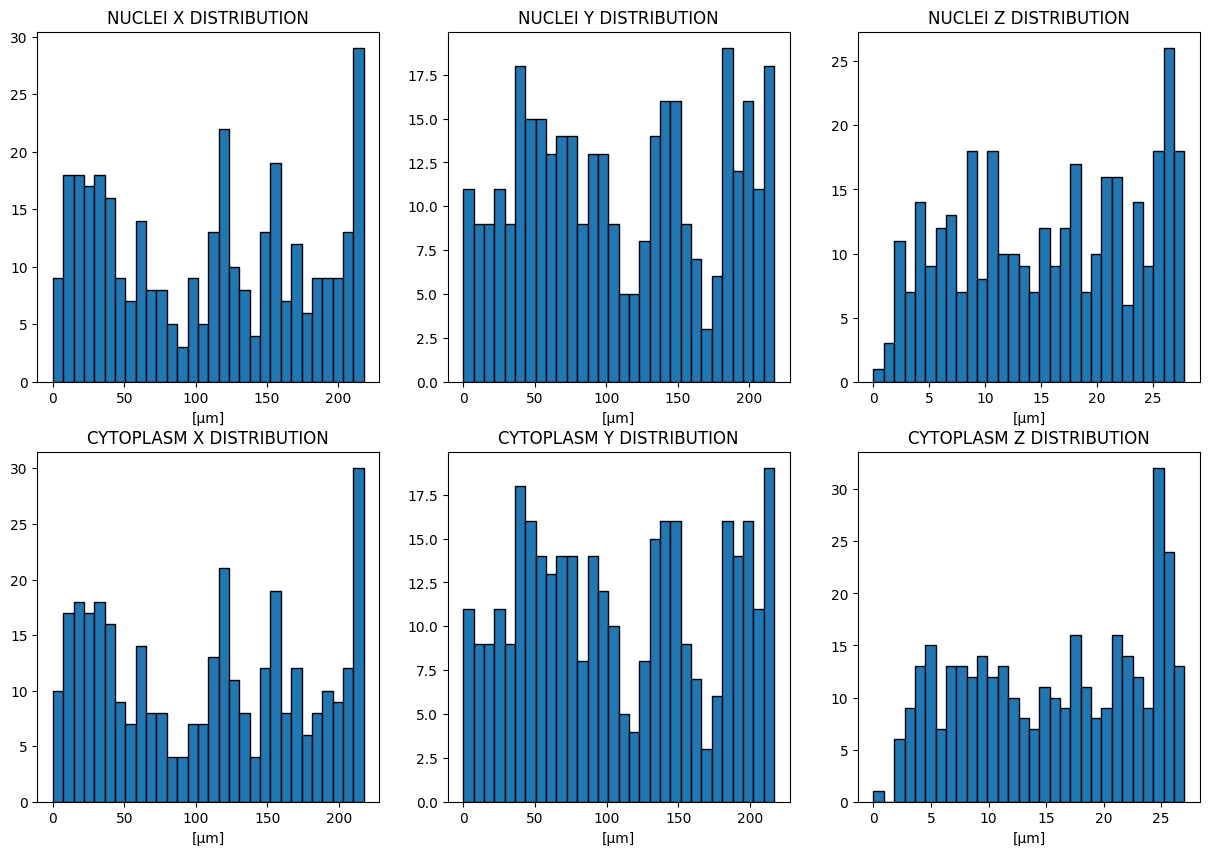

TOTAL AGGREGATES 0


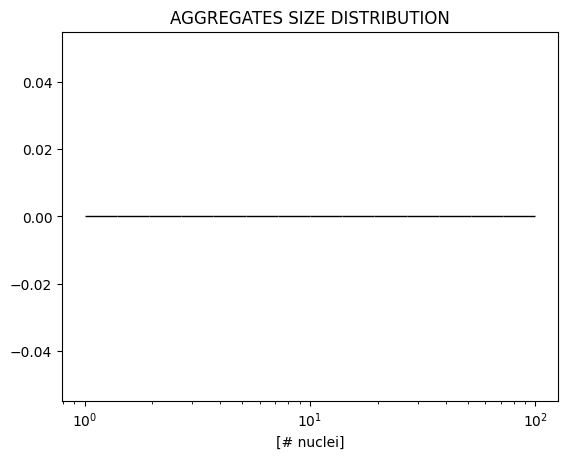

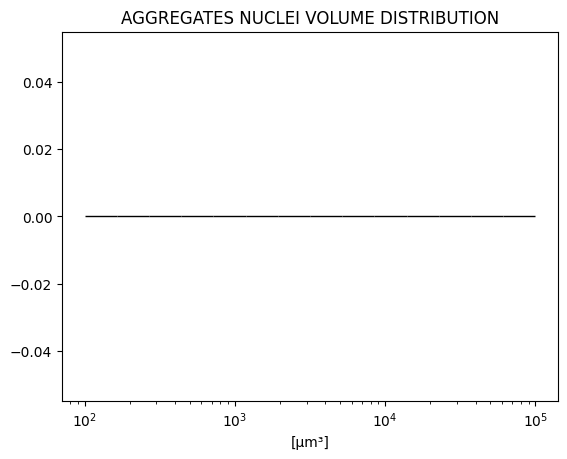

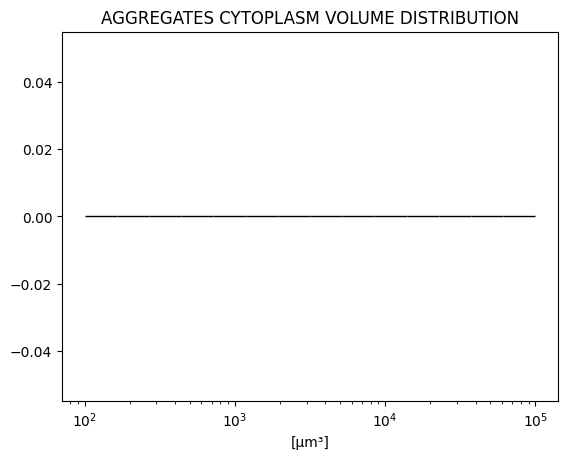

In [17]:
print('TOTAL NUCLEI ' + str(len(list_positive)))
plt.hist(nuc_vol,bins=30,range=(min(nuc_vol),max(nuc_vol)),edgecolor='black')
plt.title('NUCLEI VOLUME DISTRIBUTION') 
plt.xlabel('[μm\u00b3]')
plt.savefig(zstack_file[:-4]+'_nuclei_volume.tiff')
plt.show()
plt.hist(cyto_vol,bins=30,range=(min(cyto_vol),max(cyto_vol)),edgecolor='black')
plt.title('CYTOPLASM VOLUME DISTRIBUTION') 
plt.xlabel('[μm\u00b3]')
plt.savefig(zstack_file[:-4]+'_cytoplasm_volume.tiff')
plt.show()
fig, axs = plt.subplots(2,3,figsize=(15,10))
axs[0,0].hist(nuc_coord[1:,coord_order.find('X')],bins=30,range=(min(nuc_coord[1:,coord_order.find('X')]),max(nuc_coord[1:,coord_order.find('X')])),edgecolor='black')
axs[0,0].set_title('NUCLEI X DISTRIBUTION')
axs[0,0].set_xlabel('[μm]')
axs[1,0].hist(cyto_coord[1:,coord_order.find('X')],bins=30,range=(min(cyto_coord[1:,coord_order.find('X')]),max(cyto_coord[1:,coord_order.find('X')])),edgecolor='black')
axs[1,0].set_title('CYTOPLASM X DISTRIBUTION')
axs[1,0].set_xlabel('[μm]')
axs[0,1].hist(nuc_coord[1:,coord_order.find('Y')],bins=30,range=(min(nuc_coord[1:,coord_order.find('Y')]),max(nuc_coord[1:,coord_order.find('Y')])),edgecolor='black')
axs[0,1].set_title('NUCLEI Y DISTRIBUTION')
axs[0,1].set_xlabel('[μm]')
axs[1,1].hist(cyto_coord[1:,coord_order.find('Y')],bins=30,range=(min(cyto_coord[1:,coord_order.find('Y')]),max(cyto_coord[1:,coord_order.find('Y')])),edgecolor='black')
axs[1,1].set_title('CYTOPLASM Y DISTRIBUTION')
axs[1,1].set_xlabel('[μm]')
axs[0,2].hist(nuc_coord[1:,coord_order.find('Z')],bins=30,range=(min(nuc_coord[1:,coord_order.find('Z')]),max(nuc_coord[1:,coord_order.find('Z')])),edgecolor='black')
axs[0,2].set_title('NUCLEI Z DISTRIBUTION')
axs[0,2].set_xlabel('[μm]')
axs[1,2].hist(cyto_coord[1:,coord_order.find('Z')],bins=30,range=(min(cyto_coord[1:,coord_order.find('Z')]),max(cyto_coord[1:,coord_order.find('Z')])),edgecolor='black')
axs[1,2].set_title('CYTOPLASM Z DISTRIBUTION')
axs[1,2].set_xlabel('[μm]')
plt.show()

# CELL MARKERS

In [18]:
channel_list=['F4_80','CD80','CD206']

blocks=pv.MultiBlock()

for j in range(1,int(np.max(cytolab))+1):
    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(DAPIlab==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)  
    mr.saveMesh(mesh_stl, "part_cyto_mesh.stl" )
    
    mesh_cyto = pv.read("part_cyto_mesh.stl")
    mesh_cyto.decimate(target_reduction=0.8, inplace=True)    
    mesh_cyto.cell_data['id']=np.ones(mesh_cyto.n_cells)*j
    for c, channel in enumerate(channel_list):
        ass_channel=globals()[channel+'lab']*(DAPIlab==j)/np.max(globals()[channel+'lab'])
        mesh_cyto.cell_data[channel+'_perc']=np.ones(mesh_cyto.n_cells)*(np.sum(ass_channel)/np.sum(DAPIlab==j))
        ass_channel_2=globals()[channel+'mag']*(DAPIlab==j)/np.max(globals()[channel+'mag'])
        mesh_cyto.cell_data[channel+'_perc_2']=np.ones(mesh_cyto.n_cells)*(np.sum(ass_channel_2)/np.sum(DAPIlab==j))
    # globals()['mesh_'+channel].cell_data[channel+'_vol']=np.ones(globals()['mesh_'+channel].n_cells)*globals()[channel+'_vol'][j-1]
    # globals()['mesh_'+channel].cell_data[channel+'_agg_id']=np.ones(globals()['mesh_'+channel].n_cells)*agg_ass[j-1]
    # globals()['mesh_'+channel].cell_data[channel+'_agg_vol']=np.ones(globals()['mesh_'+channel].n_cells)*globals()[channel+'_agg_vol'][agg_ind-1]
    # globals()['mesh_'+channel].cell_data[channel+'_agg_size']=np.ones(globals()['mesh_'+channel].n_cells)*agg_size[agg_ind-1]
    
    blocks.append(mesh_cyto)
    
blocks.extract_geometry().save(zstack_file[:-4]+'_markers.vtk')

### Create a complete report XSL

In [ ]:
workbook=xlsxwriter.Workbook(zstack_file[:-4]+'.xlsx')

## FORMATS
header=workbook.add_format({'bold':True})
header.set_bg_color('yellow')
floats=workbook.add_format({'num_format':'0.00'})
floats_perc=workbook.add_format({'num_format':'0.00%'})

## CHONDROCYTES
worksheet_cell=workbook.add_worksheet('Macrophages')

#HEADER
worksheet_cell.write_row('A1:E1',['#ID','X','Y','Z','Volume Nuclei'],header)
for c, channel in enumerate(channel_list):
    worksheet_cell.write(0,5+c*2,channel,header)
    worksheet_cell.write(0,6+c*2,channel+' % vol',header)
    
#CONTENT
for row in range(1,int(np.max(cytolab))+1):
    worksheet_cell.write(row,0,row)
    worksheet_cell.write(row,1,nuc_coord[row-1][coord_order.find('X')],floats)
    worksheet_cell.write(row,2,nuc_coord[row-1][coord_order.find('Y')],floats)
    worksheet_cell.write(row,3,nuc_coord[row-1][coord_order.find('Z')],floats)
    worksheet_cell.write(row,4,nuc_vol[row-1],floats)
    for c, channel in enumerate(channel_list):
        ass_channel=globals()[channel+'lab']*(DAPIlab==row)/np.max(globals()[channel+'lab'])
        worksheet_cell.write(row,5+c*2,np.sum(ass_channel),floats)
        worksheet_cell.write(row,6+c*2,np.sum(ass_channel)/np.sum(DAPIlab==row),floats_perc)

workbook.close()

##### Create FE model

In [ ]:
simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(DAPIseg))
floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)

outVerts = mrn.getNumpyVerts(mesh_stl)
#print(outVerts)

outFaces = mrn.getNumpyFaces(mesh_stl.topology)

tet = tetgen.TetGen(outVerts,outFaces)
nodes,elems=tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5)

tet.write('FE_segmentation_full.vtk', binary=False)

grid = tet.grid
grid.plot(show_edges=True)

#### Create sections in .inp file

In [ ]:
meshel = meshio.read('FE_segmentation_full.vtk')
meshel.write('FE_segmentation.inp')

for c in range(1, np.max(DAPIlab)+1):
    globals()[str(c)+'cell_el']=[]

for ce, x in enumerate(elems):
    #print(np.shape(np.uint16(np.mean(nodes[x],0))))
    coord=np.int16(np.round(np.mean(nodes[x],0),0))
    step=0
    taken=False
    while not(taken):
        step+=1
        coord[coord<step]=1
        for k in [0,1,2]:
            if coord[k]>=np.shape(DAPIlab)[k]+1-step:coord[k]=np.shape(DAPIlab)[k]-1
        elemlist=DAPIlab[coord[0]-step:coord[0]+1+step,coord[1]-step:coord[1]+1+step,coord[2]-step:coord[2]+1+step].flatten()
        #print(elemlist)
        if sum(elemlist)>0:
            c_el=st.mode(elemlist[elemlist!=0])
            taken=True

    #print(c_el)
    if c_el!=0:
        globals()[str(c_el)+'cell_el'].append(ce+1)

f = open("FE_segmentation.inp", "a")
for c in range(1,np.max(DAPIlab)+1):
    f.write("*Elset, elset=cell" + str(c) + "\n")
    j=1
    for t in range(1, np.size(globals()[str(c)+'cell_el'])):
        f.write(str(globals()[str(c)+'cell_el'][t]) + ",")
        j+=1
        if j>16:
            f.write("\n")
            j=1
    f.write("\n")

    
f.close()

# <span style="color:red">SANDBOX</span>

81.0
200


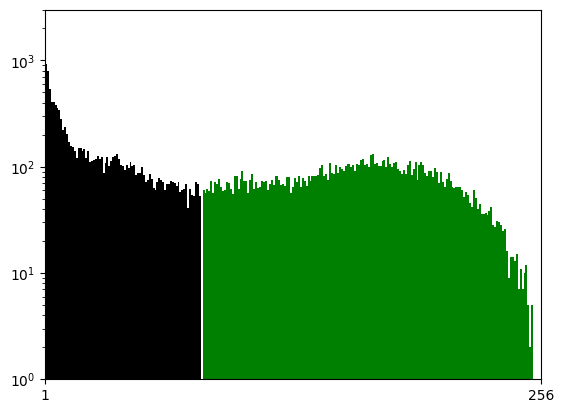

In [11]:
from PIL import Image
colormaps=['yellow','red','green','blue']
ch_names=['NFkB', 'Col_II', 'Agg', 'DAPI']
coord_order='ZYX'
viewer_0 = napari.Viewer()
c=3
c_name=ch_names[c]
im_in=img.get_image_data(coord_order, C=c, S=0, T=0)
print_im=im_in[20:27,500:-400,500:-400].copy()
im_in=print_im.copy()
out=im_in.copy()
#print(print_im[j])

# REMOVE NOISE
if trig_remove_noise:
    for p in range(0,im_in.shape[0]):
        img_bw = 255.0*(im_in[p,]> 5.0).astype('uint8')

        se1 = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
        se2 = cv.getStructuringElement(cv.MORPH_RECT, (2,2))
        mask = cv.morphologyEx(img_bw, cv.MORPH_CLOSE, se1)
        mask = cv.morphologyEx(mask, cv.MORPH_OPEN, se2)
        
        mask = np.dstack([mask]) / 255.0
        out[p,] = im_in[p,] * mask[:,:,0]

    print_im=out.copy()
    im_out=out.copy()

#HISTOGRAM TRANSFORMATION
im_in=out.copy()

#print(np.max(im_in))
if trig_transform:
    gamma=2.0
    val_a=0.005
    func_list=[contr_limit(contr_limit(contr_limit(im_in,10,20),100,240),150,250),cont_stretch(im_in),contr_limit(im_in,2,6),ln_trans(im_in)] 
    #func_list=[contr_limit(gamma_trans(gamma_trans(gamma_trans(gamma_trans(hist_slide_dec(hist_slide_inc(im_in,240),240),2.2),10.0),2.0),5.0),0.95,0.99),cont_stretch(im_in),gamma_trans(im_in,1.2),ln_trans(im_in)] 
    #func_list=[gamma_trans(im_in,1.0),cont_stretch(im_in),gamma_trans(im_in,1.2),ln_trans(im_in)] 
    im_out=func_list[c]
    #print(np.max(im_out))
else:  
    im_out=im_in.copy()


print_im=im_out.copy()

#FILTERING
if trig_filter:
    im_out=filters.gaussian(im_out,1.0)
    im_out=(im_out*255/np.max(im_out)).astype(int)
    #print(np.max(im_out))

print_im=im_out.copy()

#THRESHOLD

if trig_threshold:
    nda=sitk.GetImageFromArray(im_out)
    
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(0)
    otsu_filter.SetOutsideValue(200)
    seg = otsu_filter.Execute(nda)

    val=otsu_filter.GetThreshold()
    print(val)
    
    seg_2=sitk.GetArrayFromImage(seg)

    globals()[c_name+'seg']=seg_2.copy()
    print_im=seg_2.copy()

for j in range(0,7):
    # print_im[j].show()
    im=Image.fromarray((print_im[j]*255).astype(np.uint16))
    im.save(str(j)+c_name+'thresh.tiff')

viewer_0.add_image(print_im, name=c_name, 
                    colormap=colormaps[c], blending='additive')

hist,bins = np.histogram(print_im.flatten(),256,[1,256])

cdf = hist.cumsum()
cdf_normalized = cdf* hist.max()/ cdf.max()

val=int(val)

#plt.plot(cdf_normalized, color = 'b')
plt.hist(im_out.flatten(),255-val,[val+1,256],color = 'g')
plt.hist(im_out.flatten(),val,[1,val],color = 'k')
print(print_im.max())
plt.xlim([1,256])
plt.ylim([1,3000]) #cdf.max()])
#axs[a[c],b[c]].set_ylim([0,100])
#plt.legend(('cdf','histogram'), loc = 'upper left'),
#plt.title(c_name)
plt.xticks([1,256])
plt.yscale('log')
plt.savefig('aggthresh.svg')

53.0
61.0
41.0
81.0
Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.
1
2
3
4
1
2
3
4
5
1
2
3
4
1
2
3
4
5
6
[1, 4.0]
[1]
[1, 4.0]
[1, 4]
[2, 3.0]
[2]
[2, 3.0]
[2, 3]


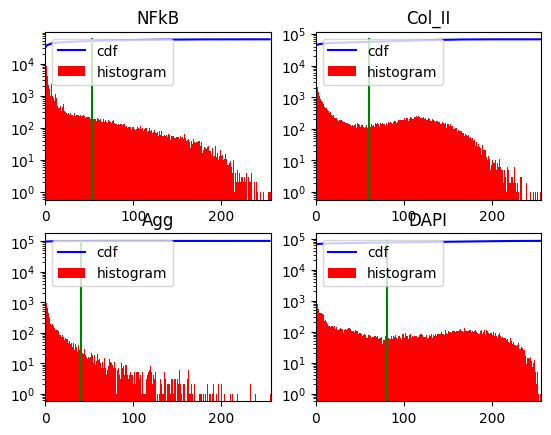

In [16]:
viewer_0 = napari.Viewer()
if trig_watershed:
    viewer_1=napari.Viewer()
img = AICSImage(zstack_file) 

colormaps=['yellow','red','green','blue']
ch_names=['NFkB', 'Col_II', 'Agg', 'DAPI']
coord_order='ZYX'

fig, axs = plt.subplots(2,2)

for c, c_name in enumerate(ch_names):
    im_in=img.get_image_data(coord_order, C=c, S=0, T=0)
    im_in=im_in[20:27,500:-400,500:-400].copy()
    out=im_in.copy()
    #print(out.shape)
    print_im=out.copy()
    im_out=im_in.copy()

    # REMOVE NOISE
    if trig_remove_noise:
        for p in range(0,im_in.shape[0]):
            img_bw = 255.0*(im_in[p,]> 5.0).astype('uint8')
    
            se1 = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
            se2 = cv.getStructuringElement(cv.MORPH_RECT, (2,2))
            mask = cv.morphologyEx(img_bw, cv.MORPH_CLOSE, se1)
            mask = cv.morphologyEx(mask, cv.MORPH_OPEN, se2)
            
            mask = np.dstack([mask]) / 255.0
            out[p,] = im_in[p,] * mask[:,:,0]

        print_im=out.copy()
        im_out=out.copy()

    #HISTOGRAM TRANSFORMATION
    im_in=out

    if trig_transform:
        gamma=2.0
        val_a=0.005
        func_list=[contr_limit(contr_limit(contr_limit(im_in,10,20),100,240),150,250),cont_stretch(im_in),contr_limit(im_in,2,6),ln_trans(im_in)] 
        im_out=func_list[c]
    else:  
        im_out=im_in.copy()

    print_im=im_out.copy()

    #FILTERING
    if trig_filter:
        im_out=filters.gaussian(im_out,1.0)
        im_out=(im_out*255/np.max(im_out)).astype(int)

    print_im=im_out.copy()

    #THRESHOLDING
    if trig_threshold:
        nda=sitk.GetImageFromArray(im_out)
        
        otsu_filter = sitk.OtsuThresholdImageFilter()
        otsu_filter.SetInsideValue(0)
        otsu_filter.SetOutsideValue(200)
        seg = otsu_filter.Execute(nda)
    
        val=otsu_filter.GetThreshold()
        print(val)
        
        seg_2=sitk.GetArrayFromImage(seg)

        globals()[c_name+'seg']=seg_2.copy()
        print_im=seg_2.copy()

    #WATERSHED
    labels=print_im
    
    if trig_threshold and trig_watershed and ch_names[c]=='DAPI':
        if trig_stardist:
            model = StarDist3D.from_pretrained('3D_demo')
            img_te = normalize(im_out,1,99.8)
            labels, _ = model.predict_instances(img_te)
        else:
            distance = ndi.distance_transform_edt(seg_2)
            coords = peak_local_max(distance, footprint=np.ones((3,3,3)), labels=seg_2)
            mask = np.zeros(distance.shape, dtype=bool)
            mask[tuple(coords.T)] = True
            markers, _ = ndi.label(mask)
            labels = watershed(-distance, markers, mask=seg_2)

    cm=np.random.rand(1000,3)
    cm[0,:]=[0.0,0.0,0.0]
    colormaps_water=Colormap(cm)

    globals()[c_name+'lab']=labels.copy()
    print_im_water=labels.copy()

    #VTK NUCLEI and CYTOPLASM CREATOR LABELLED

    if trig_threshold and trig_watershed and trig_vtk_creation and ch_names[c]=='DAPI':
        diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
        cytolab=np.zeros(np.shape(DAPIlab))
        blocks_nuclei=pv.MultiBlock()
        blocks_cyto=pv.MultiBlock()
        nuclei_stl_old=mr.Mesh()
        cyto_stl_old=mr.Mesh()
        
        agg=[]
        agg_k=[]
        agg_done=[]
        agg_k_done=[]
        agg_size=[]
        agg_cyto_vol=[]
        agg_nuc_vol=[]
        agg_nuc_coord=[]
        agg_cyto_coord=[]
        agg_ass=np.zeros(np.max(DAPIlab))
        nuc_vol=np.zeros(np.max(DAPIlab))
        cyto_vol=np.zeros(np.max(DAPIlab))
        nuc_coord=np.zeros((np.max(DAPIlab),3))
        cyto_coord=np.zeros((np.max(DAPIlab),3))
        agg_id=1

        # EVALUATE CYTOPLASM AS % MORE VOLUME COMPARED TO DAPI
        
        for j in range(0,np.max(DAPIlab)):
            simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(DAPIlab==j+1))
            floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
            mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)    
            mr.saveMesh(mesh_stl, "part_nuclei_mesh.stl" )
            
            mesh_nuclei = pv.read("part_nuclei_mesh.stl")
            mesh_nuclei.decimate(target_reduction=0.8, inplace=True)
            
            #mesh_nuclei.cell_data['nuceli_id']=np.ones(mesh_nuclei.n_cells)*j

            nuc_vol[j]=mesh_nuclei.volume
            nuc_coord[j]=mesh_nuclei.center
            #mesh_nuclei.cell_data['nuclei_vol']=np.ones(mesh_nuclei.n_cells)*mvol

            cyto_vol_control=0.0
            vol_iter=0
            while cyto_vol_control<nuc_vol[j]*(1.0+1.0):
                vol_iter+=1
                print(vol_iter)
                cyto_geo = ndi.binary_dilation(DAPIlab==j+1, diamond, iterations=vol_iter)
                cyto_geo*=((DAPIlab==j+1)+((DAPIlab==0)*(cytolab==0)))
                simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(cyto_geo))
                floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
                mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)    
                mr.saveMesh(mesh_stl, "part_cyto_mesh.stl" )
                
                mesh_cyto = pv.read("part_cyto_mesh.stl")
                mesh_cyto.decimate(target_reduction=0.8, inplace=True)
                cyto_vol_control=mesh_cyto.volume

            cyto_vol[j]=mesh_cyto.volume
            cyto_coord[j]=mesh_cyto.center
            #print(np.shape(DAPIlab))
            cytolab+=(cyto_geo*(j+1)*(cytolab==0))

        for j in range(1,np.max(DAPIlab)+1):
            simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(DAPIlab==j))
            floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
            mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)    
            mr.saveMesh(mesh_stl,"part_nuclei_mesh.stl" )
            
            mesh_nuclei = pv.read("part_nuclei_mesh.stl")
            mesh_nuclei.decimate(target_reduction=0.8, inplace=True)

            simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(cytolab==j))
            floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
            mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)    
            mr.saveMesh(mesh_stl,"part_cyto_mesh.stl" )
            
            mesh_cyto = pv.read("part_cyto_mesh.stl")
            mesh_cyto.decimate(target_reduction=0.8, inplace=True)

            if j not in agg_done:
                agg_k=[]
                agg_k_done=[]
                agnucvol=0
                agcytovol=0
                agnuccoord=np.zeros(3)
                agcytocoord=np.zeros(3)
                complete=False
                k=int(j)
                while not complete:
                    agg=[k]
                    fi=np.argwhere(cytolab==k)
                    for r in fi:
                        r[r<1]=1
                        for u in [0,1,2]:
                            if r[u]>=np.shape(DAPIlab)[u]:r[u]=np.shape(DAPIlab)[u]-1
                        elemlist=cytolab[r[0]-1:r[0]+2,r[1]-1:r[1]+2,r[2]-1:r[2]+2].flatten()
                        elemlist=elemlist[elemlist!=0]
                        agg=list(set(agg+list(set(elemlist))))
                    agg_k=list(set(agg_k+agg))
                    agg_k_done=list(set(agg_k_done+[k]))
                    agg_done=list(set(agg_done+[k]))
                    #print(k-1)
                    agg_ass[k-1]=agg_id
                    agnucvol+=nuc_vol[k-1]
                    agcytovol+=cyto_vol[k-1]
                    agnuccoord+=nuc_coord[k-1]
                    agcytocoord+=cyto_coord[k-1]
                    print(agg_k)
                    print(agg_k_done)
                    if sorted(agg_k)!=sorted(agg_k_done):
                        agg_k_todo=list(set(agg_k)-set(agg_k_done))
                        k=int(agg_k_todo[0])
                    else:
                        agg_size.append(np.size(agg_k))
                        agg_nuc_vol.append(agnucvol)
                        agg_cyto_vol.append(agcytovol)
                        agg_nuc_coord.append(agnuccoord/np.size(agg_k))
                        agg_cyto_coord.append(agcytocoord/np.size(agg_k))
                        agg_id+=1
                        complete=True

            mesh_nuclei.cell_data['nuceli_id']=np.ones(mesh_nuclei.n_cells)*j
            mesh_nuclei.cell_data['nuclei_vol']=np.ones(mesh_nuclei.n_cells)*nuc_vol[j-1]
            mesh_nuclei.cell_data['nuclei_'+coord_order[0]]=np.ones(mesh_nuclei.n_cells)*nuc_coord[j-1][0]
            mesh_nuclei.cell_data['nuclei_'+coord_order[1]]=np.ones(mesh_nuclei.n_cells)*nuc_coord[j-1][1]
            mesh_nuclei.cell_data['nuclei_'+coord_order[2]]=np.ones(mesh_nuclei.n_cells)*nuc_coord[j-1][2]
            mesh_nuclei.cell_data['nuclei_agg_'+coord_order[0]]=np.ones(mesh_nuclei.n_cells)*agg_nuc_coord[int(agg_ass[j-1])-1][0]
            mesh_nuclei.cell_data['nuclei_agg_'+coord_order[1]]=np.ones(mesh_nuclei.n_cells)*agg_nuc_coord[int(agg_ass[j-1])-1][1]
            mesh_nuclei.cell_data['nuclei_agg_'+coord_order[2]]=np.ones(mesh_nuclei.n_cells)*agg_nuc_coord[int(agg_ass[j-1])-1][2]
            mesh_nuclei.cell_data['nuclei_agg_id']=np.ones(mesh_nuclei.n_cells)*agg_ass[j-1]
            mesh_nuclei.cell_data['nuclei_agg_size']=np.ones(mesh_nuclei.n_cells)*agg_size[int(agg_ass[j-1])-1]
            mesh_nuclei.cell_data['nuclei_agg_vol']=np.ones(mesh_nuclei.n_cells)*agg_nuc_vol[int(agg_ass[j-1])-1]
            mesh_nuclei.cell_data['nuclei_agg']=np.ones(mesh_nuclei.n_cells)*(1+int(agg_size[int(agg_ass[j-1])-1]>1))

            mesh_cyto.cell_data['cyto_id']=np.ones(mesh_cyto.n_cells)*j
            mesh_cyto.cell_data['cyto_vol']=np.ones(mesh_cyto.n_cells)*cyto_vol[j-1]
            mesh_cyto.cell_data['cyto_'+coord_order[0]]=np.ones(mesh_cyto.n_cells)*cyto_coord[j-1][0]
            mesh_cyto.cell_data['cyto_'+coord_order[1]]=np.ones(mesh_cyto.n_cells)*cyto_coord[j-1][1]
            mesh_cyto.cell_data['cyto_'+coord_order[2]]=np.ones(mesh_cyto.n_cells)*cyto_coord[j-1][2]
            mesh_cyto.cell_data['cyto_agg_'+coord_order[0]]=np.ones(mesh_cyto.n_cells)*agg_cyto_coord[int(agg_ass[j-1])-1][0]
            mesh_cyto.cell_data['cyto_agg_'+coord_order[1]]=np.ones(mesh_cyto.n_cells)*agg_cyto_coord[int(agg_ass[j-1])-1][1]
            mesh_cyto.cell_data['cyto_agg_'+coord_order[2]]=np.ones(mesh_cyto.n_cells)*agg_cyto_coord[int(agg_ass[j-1])-1][2]
            mesh_cyto.cell_data['cyto_agg_id']=np.ones(mesh_cyto.n_cells)*agg_ass[j-1]
            mesh_cyto.cell_data['cyto_agg_size']=np.ones(mesh_cyto.n_cells)*agg_size[int(agg_ass[j-1])-1]
            mesh_cyto.cell_data['cyto_agg_vol']=np.ones(mesh_cyto.n_cells)*agg_cyto_vol[int(agg_ass[j-1])-1]
            mesh_cyto.cell_data['cyto_agg']=np.ones(mesh_cyto.n_cells)*(1+int(agg_size[int(agg_ass[j-1])-1]>1))
        
            blocks_nuclei.append(mesh_nuclei)
            blocks_cyto.append(mesh_cyto)
        
        blocks_nuclei.extract_geometry().save(zstack_file[:-4]+'_DAPI_nuclei_labelled.vtk')
        blocks_cyto.extract_geometry().save(zstack_file[:-4]+'_DAPI_cytoplasm_labelled.vtk')

    #NAPARI UPLOAD
    viewer_0.add_image(print_im, name=c_name, 
                        colormap=colormaps[c], blending='additive')
    if trig_watershed:
        viewer_1.add_image(print_im_water, name=c_name, 
                            colormap=colormaps_water, blending='additive')

    viewer_0.scale_bar.visible=True
    viewer_0.scale_bar.unit='um'
    
    #STL CREATOR
    if trig_stl_creation:
        simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(labels))
        floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
        mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)
        mr.saveMesh(mesh_stl, zstack_file[:-4]+"_"+ch_names[c]+"_mesh.stl" )

    #HISTOGRAM PLOTTING
    hist,bins = np.histogram(im_out.flatten(),256,[0,256])
    
    cdf = hist.cumsum()
    cdf_normalized = cdf* hist.max()/ cdf.max()

    axs[a[c],b[c]].plot(cdf_normalized, color = 'b')
    axs[a[c],b[c]].hist(im_out.flatten(),256,[0,256], color = 'r')
    axs[a[c],b[c]].set_xlim([0,256])
    #axs[a[c],b[c]].set_ylim([0,100])
    axs[a[c],b[c]].legend(('cdf','histogram'), loc = 'upper left'),
    if trig_threshold:
        axs[a[c],b[c]].plot([val,val],[0,cdf_normalized.max()],color='g')
    axs[a[c],b[c]].set_title(c_name)
    axs[a[c],b[c]].set_yscale('log')

0.0,
0.07523418524102965,
0.7037760343664446,
0.8976196592539372,
0.005,
0.06061195540710296,
0.5704990513121697,
0.7176987959731093,
0.01,
0.5989660953572982,
0.8348501318892342,
0.5989355846291774,
0.015,
0.604940748346121,
0.9377991547504874,
0.4355687122326407,
0.02,
0.981832782250357,
0.550312253308683,
0.41557384681653675,
0.025,
0.1141665587108125,
0.809150239263133,
0.6559310840818434,
0.03,
0.5167453064051213,
0.717599703235585,
0.23322349425416455,
0.035,
0.7424660031679613,
0.8406582066368248,
0.12903233917988643,
0.04,
0.704593049237546,
0.5960547773886041,
0.5577696503290804,
0.045,
0.7972775440478171,
0.5761073995262923,
0.6809892540062003,
0.05,
0.5434099566053368,
0.031265167901420865,
0.8193640618236776,
0.055,
0.4046064143732008,
0.796817719101795,
0.3444806045211569,
0.06,
0.7356665681844973,
0.47689996520019995,
0.35195283342792627,
0.065,
0.17637090276984946,
0.9103254656059032,
0.0063426547702521985,
0.07,
0.733724091082988,
0.8358203534488646,
0.18042152959931945

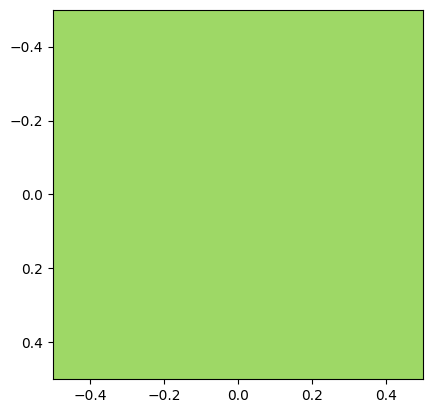

In [63]:
import random
from skimage import io
for j in range(0,201):
    v_1=1.0
    v_2=1.0
    v_3=1.0
    while(not((v_1**2+v_2**2+v_3**2>0.8)&(v_1**2+v_2**2+v_3**2<1.5))):
        v_1=random.uniform(0,1)
        v_2=random.uniform(0,1)
        v_3=random.uniform(0,1)
    print(str(j/200) + ',')
    print(str(v_1) + ',')
    print(str(v_2) + ',')
    print(str(v_3) + ',')
    

print(v_1)
print(v_2)
print(v_3)
print(v_1**2+v_2**2)
print(v_1**2+v_2**2+v_3**2)

plt.imshow([[(v_1,v_2,v_3)]])

In [41]:
np.shape(DAPIlab)
np.max(DAPIlab)

#cytolab=ndi.binary_dilation(DAPIlab==j, diamond, iterations=2)

cytoagglab=np.zeros(np.shape(DAPIlab))
for k in range(1,np.max(DAPIlab)):
    cytoagglab=cytoagglab+(ndi.binary_dilation(DAPIlab==k, diamond, iterations=2))*agg_ass[k-1]*(cytoagglab==0)

KeyboardInterrupt: 

In [ ]:
viewer_0 = napari.Viewer()
np.max(cytoagglab)
viewer_0.add_image(cytoagglab, name=c_name, colormap=colormaps[c], blending='additive')
viewer_0.add_image(DAPIlab, name=c_name, colormap=colormaps[c], blending='additive')

In [ ]:
blocks=pv.MultiBlock()
mesh_stl_old=mr.Mesh()

for j in range(1,int(np.max(cytoagglab))+1):
    ass_channel=NFkBseg*(cytoagglab==j)/np.max(NFkBseg)
    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(ass_channel))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(r_Z, r_Y, r_X), 0.5)    
    mr.saveMesh(mesh_stl, "part_mesh.stl" )
    
    mesh = pv.read("part_mesh.stl")
    if (mesh.volume>0.0):
        mesh.decimate(target_reduction=0.8, inplace=True)
        
        mesh.cell_data['NFkB_id']=np.ones(mesh.n_cells)*j
    
        mvol=mesh.volume
        mesh.cell_data['nuclei_vol']=np.ones(mesh.n_cells)*mvol

    blocks.append(mesh)

blocks.extract_geometry().save('test_NFkB.vtk')

In [ ]:
for j in range(1,int(np.max(DAPIagglab))):
    ass_channel=NFkBseg*(cytoagglab==j)/np.max(NFkBseg)
    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(ass_channel))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(r_Z, r_Y, r_X), 0.5)

In [ ]:
import json

json.loads('rainbow.json')

In [ ]:
import json

from matplotlib.colors import LinearSegmentedColormap
with open('rainbow.json', 'r') as f:
    my_cmap = LinearSegmentedColormap("my_cmap", json.load(f))

print(my_cmap[1])

cm=my_cmap

In [ ]:
import ColorMapWriter
import matplotlib.cm as cmap
mpl_map = cmap.viridis(np.arange(256))
c = ColorMapWriter.ColorMapWriter(mpl_map, 'viridis.xml', 5)
c.createLookupTable()

In [ ]:
print('TOTAL NUCLEI ' + str(np.max(DAPIlab)))
print('NKfB NUCLEI ' + str(np.size(ass_list)))

cm = plt.cm.get_cmap('plasma')

# Plot histogram.
n, bins, patches = plt.hist(nuc_vol,bins=50,range=(100,1400))
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.show()

plt.savefig('volume.tiff')
plt.xlabel('Nuclei volume (um3)')
#plt.show()
print('==================')
print('TOTAL AGGLOMERATES ' + str(agg_id-1))
n, bins, patches = plt.hist(agg_size,bins=10**np.linspace(0, 2, 15),edgecolor='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

#plt.yscale('log')
plt.xscale('log')

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.yscale('log')
plt.show()
plt.hist(np.array(agg_vol).clip(min=0,max=10000),bins=50)
plt.yscale('log')
plt.show()

In [ ]:
from itertools import chain
for k in chain(range(1,10),range(10,0,-1)):
    print(k)

In [ ]:
blocks=pv.MultiBlock()
mesh_stl_old=mr.Mesh()

agg=[]
agg_k=[]
agg_done=[]
agg_k_done=[]
agg_size=[]
agg_ass=np.zeros(np.max(DAPIlab))
agg_id=1

for j in range(1,np.max(DAPIlab)):
    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(labels==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(r_X, r_Y, r_Z), 0.5)    
    mr.saveMesh(mesh_stl, "part_mesh.stl" )
    
    mesh = pv.read("part_mesh.stl")
    mesh.decimate(target_reduction=0.8, inplace=True)
    
    mesh.cell_data['id']=np.ones(mesh.n_cells)*j
    
    if j not in agg_done:
        agg_k=[]
        agg_k_done=[]
        complete=False
        k=j
        while not complete:
            agg=[k]
            fi=np.argwhere(DAPIlab==k)
            for r in fi:
                r[r<1]=1
                for u in [0,1,2]:
                    if r[u]>=np.shape(DAPIlab)[u]:r[u]=np.shape(DAPIlab)[u]-1
                elemlist=DAPIlab[r[0]-1:r[0]+2,r[1]-1:r[1]+2,r[2]-1:r[2]+2].flatten()
                elemlist=elemlist[elemlist!=0]
                #print(list(set(elemlist)))
                #type(agg)
                agg=list(set(agg+list(set(elemlist))))
                #print(agg)
                # agg_done.append(k)
                # agg_k_done.append(k)
                # if agg.sort()==agg_k_done.sort():
                #     complete=True
                # else:
            agg_k=list(set(agg_k+agg))
            #print(agg_k)
            agg_k_done=list(set(agg_k_done+[k]))
            #print(agg_k_done)
            agg_done=list(set(agg_done+[k]))
            agg_ass[k]=agg_id
            #print(agg_done)
            #agg_k_done=
            if sorted(agg_k)!=sorted(agg_k_done):
                agg_k_todo=list(set(agg_k)-set(agg_k_done))
                #print(agg_k_todo)
                k=agg_k_todo[0]
                #print(k)
            else:
                #print(agg_k)
                agg_size.append(np.size(agg_k))
                agg_id+=1
                #print(agg_ass)
                complete=True
    mesh.cell_data['agg_id']=np.ones(mesh.n_cells)*agg_ass[j]
    mesh.cell_data['agg_size']=np.ones(mesh.n_cells)*agg_size[int(agg_ass[j])-1]
    mesh.cell_data['agg']=np.ones(mesh.n_cells)*(1+int(agg_size[int(agg_ass[j])-1]>1))

    blocks.append(mesh)

blocks.extract_geometry().save('DAPI_labelled_test.vtk')
                    

agg_done=[]
agg_id=1

#for j in range(1,10):
    

In [ ]:
int(agg_ass[j])

In [ ]:
agg_ass=np.zeros(50)
print(agg_ass)

In [ ]:
agg_k_done=[]
agg_k_done=list(set(agg_k_done+[4, 6, 3]))
test=sorted(agg_k_done)
print(agg_k_done)

In [ ]:
type(agg)

In [ ]:

for j in range(1,10):
    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(labels==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(r_X, r_Y, r_Z), 0.5)    
    mr.saveMesh(mesh_stl, "part_mesh.stl" )

    mesh = pv.read("part_mesh.stl")
    mesh.decimate(target_reduction=0.8, inplace=True)

    fi=np.argwhere(DAPIlab==j)
    aggregated=False
    agg=0
    for r in fi:
        r[r<1]=1
        for k in [0,1,2]:
            if r[k]>=np.shape(DAPIlab)[k]:r[k]=np.shape(DAPIlab)[k]-1
        elemlist=DAPIlab[r[0]-1:r[0]+2,r[1]-1:r[1]+2,r[2]-1:r[2]+2].flatten()
        agg=
        #print(agg)

    if agg>0:
        mesh.cell_data['id']=np.ones(mesh.n_cells)*1
    else:
        mesh.cell_data['id']=np.ones(mesh.n_cells)*2

    blocks.append(mesh)

blocks.extract_geometry().save('DAPI_labelled_new.vtk')

In [ ]:
for h in range(1,1000):
    stre=str(h/1000) + ','
    print(stre)
    str1=str(np.random.random())+','
    str2=str(np.random.random())+','
    str3=str(np.random.random())+','
    print(str1)
    print(str2)
    print(str3)

In [ ]:
import pymeshlab

In [ ]:
print(sum(elemlist))

## TEST FE SECTIONS

In [ ]:
#nodes_rearr=nodes[:,[0,1,2]]
#print([np.mean(nodes_rearr[x],0)])
#print(nodes_rearr)
for c in range(1, np.max(DAPIlab)+1):
    globals()[str(c)+'cell_el']=[]

for ce, x in enumerate(elems):
    #print(np.shape(np.uint16(np.mean(nodes[x],0))))
    coord=np.int16(np.round(np.mean(nodes[x],0),0))
    coord[coord<1]=1
    coord[coord==1024]=1023
    if coord[0]==59: coord[0]=58
    elemlist=DAPIlab[coord[0]-1:coord[0]+2,coord[1]-1:coord[1]+2,coord[2]-1:coord[2]+2].flatten()
    #print(coord)
    c_el=st.mode(elemlist[elemlist!=0])
    #print(c_el)
    if c_el!=0:
        globals()[str(c_el)+'cell_el'].append(ce+1)

In [ ]:
f = open("element_sections.txt", "w")
for c in range(1,np.max(DAPIlab)+1):
    f.write("*Elset, elset=cell" + str(c) + "\n")
    j=1
    for t in range(1, np.size(globals()[str(c)+'cell_el'])):
        f.write(str(globals()[str(c)+'cell_el'][t]) + ",")
        j+=1
        if j>16:
            f.write("\n")
            j=1
    f.write("\n")

    
f.close()

In [ ]:
np.shape(DAPIlab)[1]

In [ ]:
import csv
with open('GFG', 'w') as f:
     
    # using csv.writer method from CSV package
    write = csv.writer(f)
     
    write.writerows([globals()[str(180)+'cell_el']])

In [ ]:
import meshio

meshel = meshio.read('FE_segmentation_full.vtk')
meshel.write('testmesh.inp')

In [ ]:

simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(DAPIlab==h))
floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)

outVerts = mrn.getNumpyVerts(mesh_stl)
#print(outVerts)

outFaces = mrn.getNumpyFaces(mesh_stl.topology)

tet = tetgen.TetGen(outVerts,outFaces)
nodes_part,elems_part=tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5)

print(nodes_part)
print(elems_part)

elem_single=[]
for x in elems_part:
    j=1
    for y in elems:
        if ((x==y).all()):
            elem_single=[elem_single, j]
        else:
            j+=1
    

In [ ]:
elem_single

## TEST STARDIST

In [ ]:
from stardist.models import Config3D, StarDist3D
StarDist3D.from_pretrained()

In [ ]:
from csbdeep.utils import normalize

viewer_0 = napari.Viewer()

# prints a list of available models
StarDist3D.from_pretrained()

# creates a pretrained model
model = StarDist3D.from_pretrained('3D_demo')

img_te = normalize(im_out,1,99.8)

labels_d, _ = model.predict_instances(img_te)

# plt.subplot(1,2,1)
# plt.imshow(img_te, cmap="gray")
# plt.axis("off")
# plt.title("input image")

# plt.subplot(1,2,2)
# plt.imshow(render_label(labels_d, img=img_te))
# plt.axis("off")
# plt.title("prediction + input overlay")

viewer_0.add_image(labels_d, name=c_name, 
                    colormap=colormaps_water, blending='additive')


## TEST FINITE ELEMENT

In [ ]:
blocks=pv.MultiBlock()

mesh_stl_old=mr.Mesh()

for j in range(1,np.max(labels)):
    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(labels==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1, 1, 1), 0.5)    
    mr.saveMesh(mesh_stl, "part_mesh.stl" )

    mesh = pv.read("part_mesh.stl")
    mesh.decimate(target_reduction=0.8, inplace=True)

    mesh.cell_data['id']=np.ones(mesh.n_cells)*j

    blocks.append(mesh)

blocks.extract_geometry().save('test.vtk')
#print(mesh)

#viewer_0.add_image(test, name=c_name, 
#                        colormap=colormaps[c], blending='additive')



In [ ]:
import pyvista as pv

blocks=pv.MultiBlock()

for j in range(1,2):
    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(labels==j))
    np.shape(np.float32(labels==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1/r_X, 1/r_Y, 1/r_Z), 0.5)

    outVerts = mrn.getNumpyVerts(mesh_stl)
    print(outVerts)
    

    outFaces = mrn.getNumpyFaces(mesh_stl.topology)

    mesh_par = pv.PolyData(outVerts,outFaces)

    #mesh_par.decimate(target_reduction=0.8, inplace=True)

    mesh_par.cell_data['id']=np.ones(mesh_par.n_cells)*j

    blocks.append(mesh_par)

blocks.extract_geometry().save('test_vtk.vtk')    
    

In [ ]:
from skimage.measure import marching_cubes
#from mayavi import mlab
from scipy.spatial import Delaunay

verts, faces, normals, values = marching_cubes(np.float32(labels==400),0.0)

#print(normals)
#print([vert[2] for vert in verts])

tri = Delaunay(verts)

print(tri.simplices)

#mlab.triangular_mesh([vert[0] for vert in verts],
#                 [vert[1] for vert in verts],
#                 [vert[2] for vert in verts],
#                 tri.simplices)

In [ ]:
# u, v are parameterisation variables
u = [0,0,0.5,1,1]
v = [0,1,0.5,0,1] 

x = u
y = v
z = [0,0,1,0,0]

simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(labels==400))
floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1/r_X, 1/r_Y, 1/r_Z), 0.5)

verts = mrn.getNumpyVerts(mesh_stl)

#verts, faces, normals, values = marching_cubes(np.float32(labels==400),0.0)

xyz=np.array(verts)
print(np.transpose(normals[122]))
print(xyz)

# Triangulate parameter space to determine the triangles
#tri = mtri.Triangulation(u, v)
tri = Delaunay(xyz)

print(tri.simplices)

import meshio
mesh=meshio.Mesh(xyz,{'tetra': tri.simplices})
meshio.write('out.inp', mesh)

In [ ]:
verts[[49,101,24,8]]

In [ ]:
import pymesh
input_mesh = pymesh.generate_icosphere(1.0, [0.0, 0.0, 0.0]);
tetmesh=pymesh.tetgen()

In [ ]:
(1/r_X, 1/r_Y, 1/r_Z)

In [ ]:
import pygalmesh

print(np.max(labels))

meshing=(labels==230)

mesh9 = pygalmesh.generate_from_array(
    np.uint8(meshing), (0.1,0.1,0.1), max_cell_circumradius=0.1
)

#plt.imshow(np.uint8(labels[15]>0))

mesh9.write("ball2.inp")

In [ ]:
np.max(seg_2)
plt.imshow(meshing[15])

In [ ]:
import tetgen

#tet=tetgen.TetGen()

verts, faces, normals, values = marching_cubes(np.float32(labels>0),0.0)

tet = tetgen.TetGen(verts,faces)
tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5)

tet.write('grid_1.vtk', binary=False)

grid = tet.grid
grid.plot(show_edges=True)